In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from time import time
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from sklearn.preprocessing import scale

## User input

In [2]:
sample_prefix = 'E:\\Ashlee\\PacBio\\181207\\30s_43N43\\m181207_211324_42131_c000468682559900001500000112312060_s1_p0'

## Utility functions

In [345]:
def plot_traces(n, data, indices):
    plt.figure(figsize=(15, n*1.2))
    if n % 2 == 1:
        n = n-1
    for i in range(n):
        plt.subplot(int(n/2), 2, i+1)
        trc = data[indices[i]]
        if len(data.shape) == 2:
            plt.plot(time_axis, trc)
        else:
            for j in range(data.shape[1]):
                plt.plot(time_axis, trc[j], color=colors[j])

        plt.xlabel('Time (s)')
        plt.ylabel('Intensity')
        plt.title('Trace ' + str(i))
        
#         if i%2 == 1:
#             plt.legend(lasers, bbox_to_anchor=(0.75, 0.5, 0.5, 0.5))
        i = i + 1
    plt.subplots_adjust(hspace=0.7)

def dtw(a1, a2):
#     s1 = np.column_stack((time_axis, a1))
#     s2 = np.column_stack((time_axis, a2))
#     return fastdtw(s1, s2)[0]
    
    return fastdtw(a1.T, a2.T)[0]

def dtw_classification(data, n_classes, n_frames, rep_trc_IDs):
    start = time()

    init_class = np.zeros((n_classes, n_frames))
    
    for i in range(n_classes):
        init_class[i] = scaled_data_cy5[rep_trc_IDs[i]]

    labels = []
    for i in range(len(data)):
        trc = data[i]
        min_dist = 1e9
        curr_label = 0
        for j in range(n_classes):
            dist = dtw(trc, init_class[j])
            if dist < min_dist:
                min_dist = dist
                curr_label = j
        labels.append(curr_label)

    print("Time passed: " + str(time() - start))
    return labels

def class_extractor(labels, n_classes):
    cls_members = {}
    for i in range(len(labels)):
        cls = labels[i]
        if cls in cls_members.keys():
            cls_members[cls].append(i)
        else:
            cls_members[cls] = [i]
    return cls_members

## Load data

In [3]:
trc_filename = sample_prefix + '.trc.h5'
mcd_filename = sample_prefix + '.mcd.h5'
upd_filename = sample_prefix + '.upd.h5'
meta_filename = sample_prefix + '.metadata.xml'

trc_file = h5py.File(trc_filename, 'r')
mcd_file = h5py.File(mcd_filename, 'r')
upd_file = h5py.File(upd_filename, 'r')

# Load data in trace file
dset = trc_file['TraceData']
raw_traces = dset['Traces']
decode = dset['Codec']['Decode']
n_traces = raw_traces.shape[0]
n_frames = raw_traces.shape[2]
decode_array = np.array(decode)

# Load data in upd file
upd_TD = upd_file['TraceData']
hole_xy_plot = upd_TD['HoleXYPlot'] # (x,y) coordinates for each well
hole_status = upd_TD['HoleStatus'] # fiducials

# Extract frame rate from metadata
meta_tree = ET.parse(meta_filename)
root = meta_tree.getroot()
for keyval in root.iter('{http://pacificbiosciences.com/PAP/Metadata.xsd}KeyValue'):
    if keyval.attrib['key'] == 'MovieFPS':
        fps = int(keyval.text)
        frame_rate = 1.0/fps # seconds
        break

# For plotting
time_axis = np.arange(n_frames)*frame_rate
colors = ['green', (0, 1, 0), 'red', 'orange']
lasers = ['Cy3', 'Cy3.5', 'Cy5', 'Cy5.5']

In [4]:
# Skip decode
traces = raw_traces

## Demo of DTW

In [290]:
avg_intens = np.mean(traces, axis=2)
# zero-center the traces
centered_traces = np.zeros(raw_traces.shape)
for i in range(n_traces):
    for j in range(4):
        centered_traces[i, j] = traces[i, j] - avg_intens[i, j]

# Compute cross-correlation
corr_list = np.zeros(n_traces)
for i in range(n_traces):
    cy3 = centered_traces[i][0]
    cy5 = centered_traces[i][2]
    corr_list[i] = np.correlate(cy3, cy5)

sorting_index = np.argsort(corr_list)

In [318]:
trace1 = 0
trace2 = 4
x = centered_traces[sorting_index[trace1], [0, 2]]
y = centered_traces[sorting_index[trace2], [0, 2]]

# for lst in [x, y]:
#     for j in range(2):
#         for i in range(1, n_frames-1):
#             lst[j, i] = (lst[j, i-1] + lst[j, i] + lst[j, i+1])/3

x_min = x.min(axis=1)
x_max = x.max(axis=1)
y_min = y.min(axis=1)
y_max = y.max(axis=1)

for i in range(len(x_min)):
    x[i] = (x[i] - x_min[i])/(x_max[i] - x_min[i])
    y[i] = (y[i] - y_min[i])/(y_max[i] - y_min[i])

distance_xy, path_xy = fastdtw(x.T, y.T, dist=euclidean)

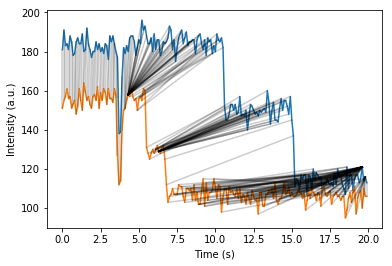

In [331]:
plt.figure()
plt.plot(time_axis, traces[sorting_index[trace1], 2, :])
plt.plot(time_axis, traces[sorting_index[trace2], 2, :])
for i in range(len(path_xy)):
    a = path_xy[i][0]
    b = path_xy[i][1]
    times = [time_axis[a], time_axis[b]]
    trcs = [traces[sorting_index[trace1], 2, a], traces[sorting_index[trace2], 2, b]]
    plt.plot(times, trcs, c='k', alpha=0.2)


plt.xlabel('Time (s)')
plt.ylabel('Intensity (a.u.)')
plt.savefig('DTW demo.png', dpi=300)

## Classification using DTW as distance metric

In [246]:
scaled_data_cy5 = np.zeros((n_traces, n_frames))

for i in range(n_traces):
    cy5_trc = centered_traces[i, 2, :]
    cy5_min = cy5_trc.min()
    cy5_max = cy5_trc.max()
    if cy5_min == cy5_max:
        scaled_data_cy5[i] = np.ones(cy5_trc.shape)
    else:
        scaled_data_cy5[i] = (cy5_trc - cy5_min) / (cy5_max - cy5_min)

In [202]:
neg_set = sorting_index[:1000]
rand_set = np.random.randint(0, n_traces, size=(1000,))

test_data2 = np.zeros((2000, n_frames))

for i in range(1000):
    m = neg_set[i]
    n = rand_set[i]
    test_data2[2*i] = scaled_data_cy5[m]
    test_data2[2*i+1] = scaled_data_cy5[n]

# smoothen the data
# for j in range(2000):
#     for i in range(1, n_frames-1):
#         test_data2[j, i] = (test_data2[j, i-1] + test_data2[j, i] + test_data2[j, i+1])/3

In [ ]:
sorting_index = np.argsort(max_jump_list)

In [ ]:
plt.figure(figsize=(15, 20))
for i in range(10):
    plt.subplot(5, 2, i+1)
    st = traces[sorting_index[n_traces-1-i]]
#     print(max_jump_list[sorting_index[n_traces-1-i]])
    for j in range(4):
        plt.plot(time_axis, st[j], color=colors[j])
        j += 1 

    plt.xlabel('Time (s)')
    plt.ylabel('Intensity')
    plt.title('Trace ' + str(i))
    plt.legend(lasers, bbox_to_anchor=(0.75, 0.5, 0.5, 0.5))
    i = i + 1

In [224]:
labels = dtw_classification(test_data2[:200], 3, n_frames, [sorting_index[0], sorting_index[1], 64050])

Time passed: 7.750000238418579


In [229]:
labels = dtw_classification(test_data2[:2000], 3, n_frames, [sorting_index[0], sorting_index[1], 64050])

Time passed: 79.02199983596802


In [231]:
labels = dtw_classification(scaled_data_cy5, 3, n_frames, [sorting_index[0], sorting_index[1], 64050])

Time passed: 6321.512200117111


In [283]:
labels = dtw_classification(test_data2, 3, n_frames, [sorting_index[1], 64050, 33104])

Time passed: 74.77809977531433


(array([1010.,    0.,    0.,    0.,    0.,  981.,    0.,    0.,    0.,
           9.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

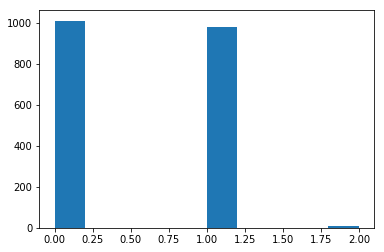

In [284]:
plt.hist(labels)

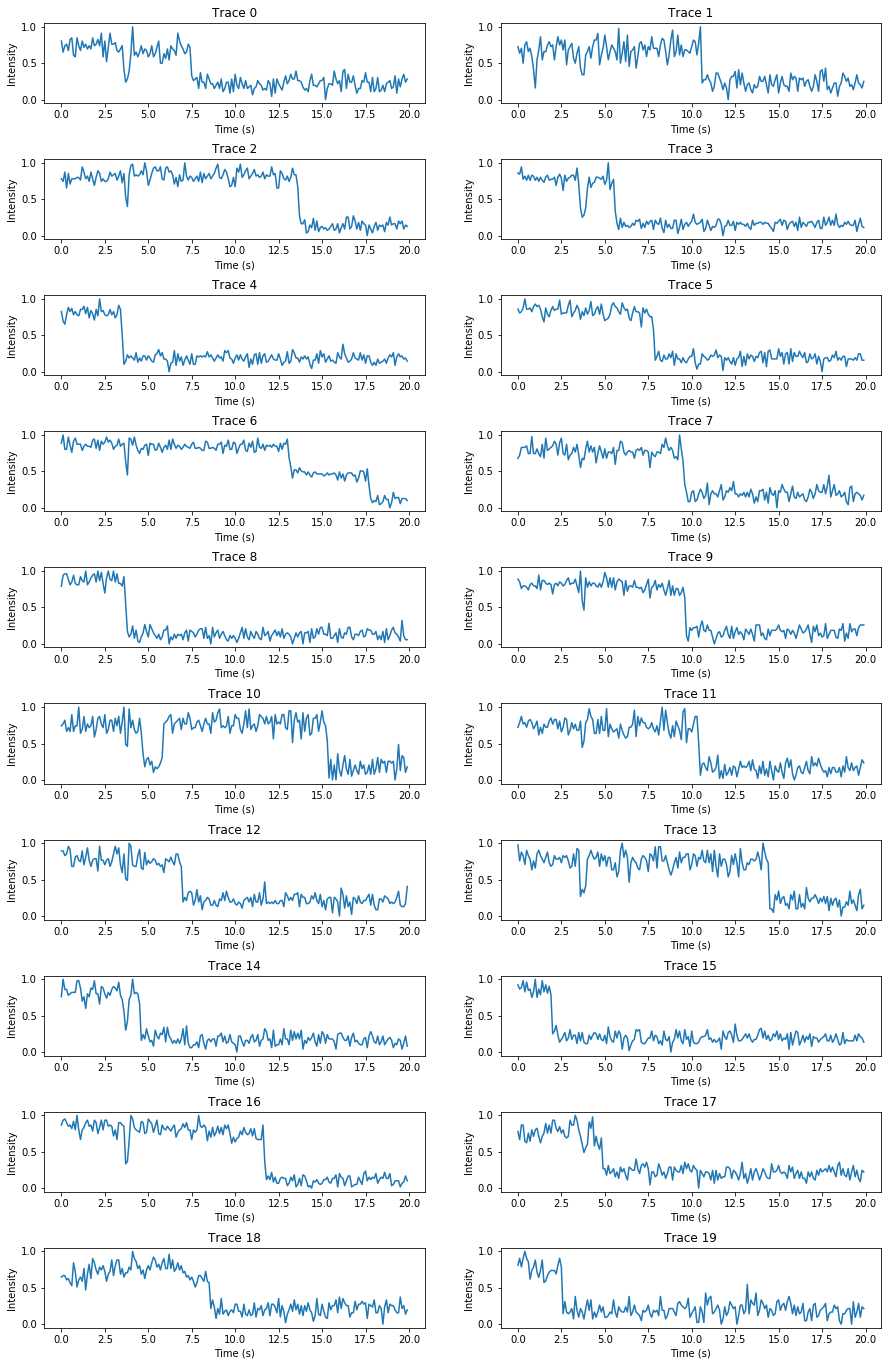

In [382]:
classes = class_extractor(labels, 3)
plot_traces(20, test_data2, np.random.choice(classes[0], size=(20,)))
plt.savefig('Class 0, 20 randome traces.png', dpi=300)

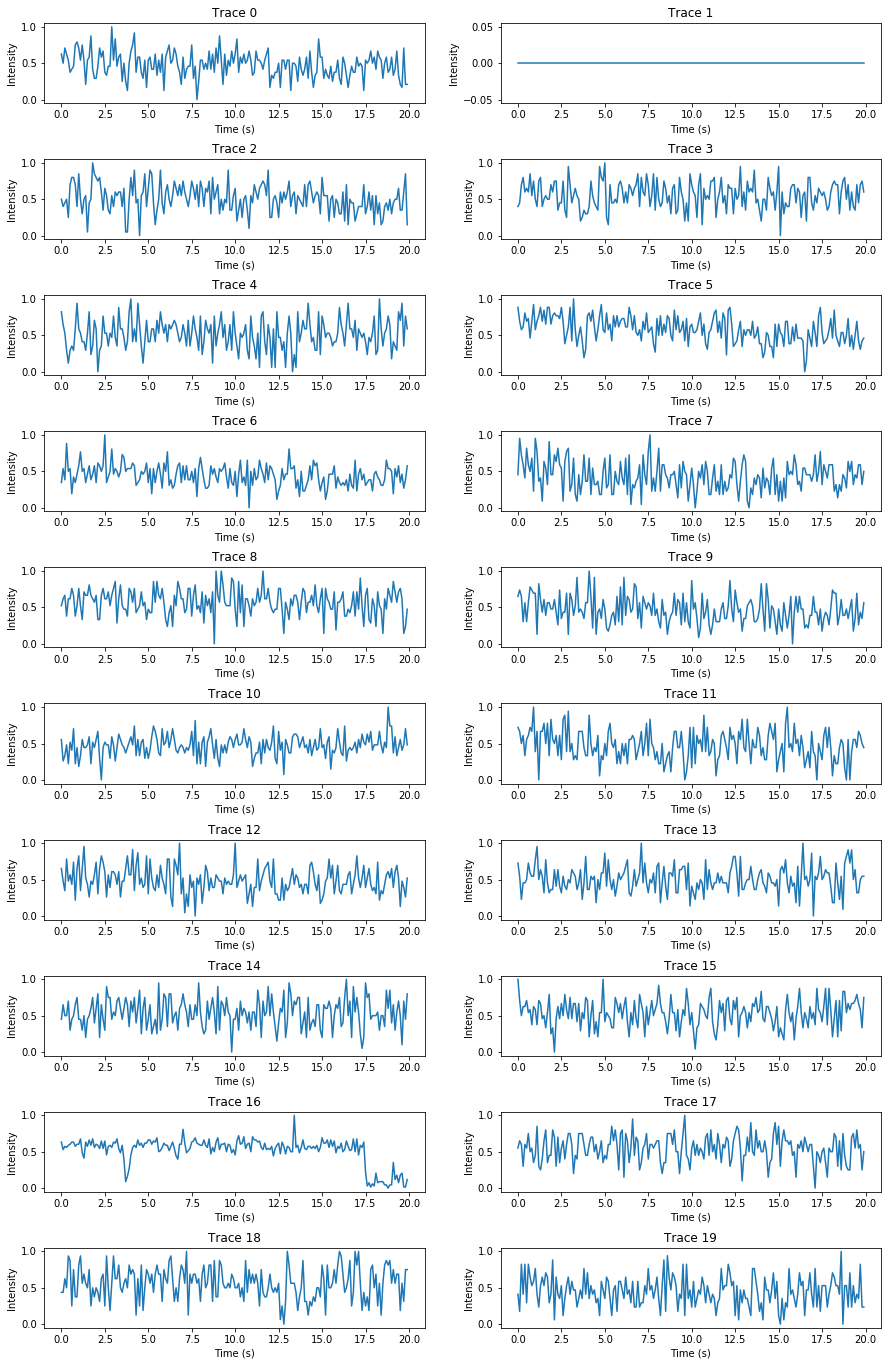

In [371]:
plot_traces(20, test_data2, np.random.choice(classes[1], size=(20,)))
plt.savefig('Class 1, 20 randome traces.png', dpi=300)

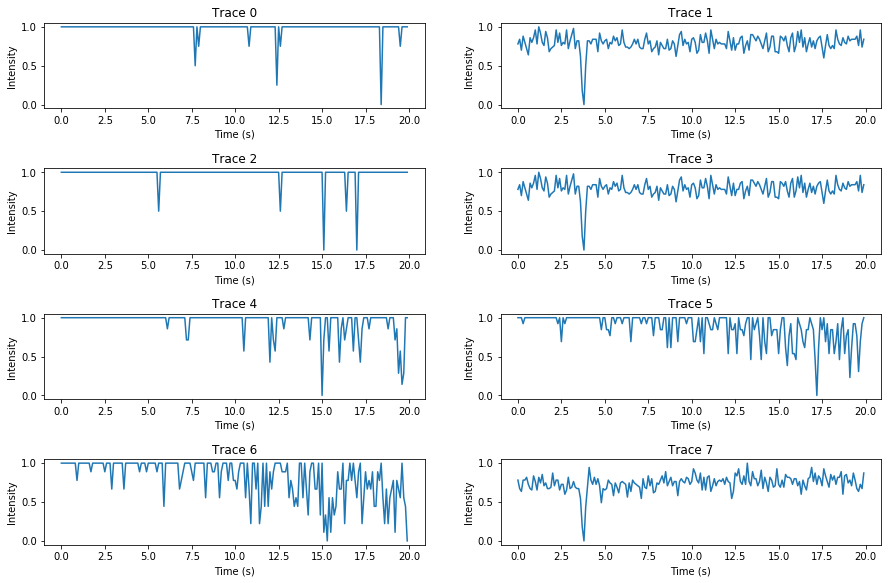

In [370]:
plot_traces(8, test_data2, np.random.choice(classes[2], size=(8,)))
plt.savefig('Class 2, 8 traces.png', dpi=300)

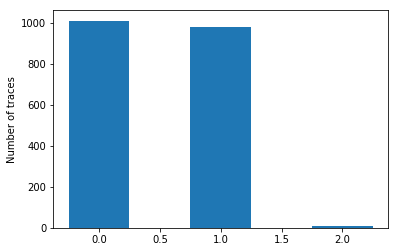

In [369]:
plt.bar([0, 1, 2], [1010, 981, 9], width=0.5)
plt.ylabel("Number of traces")
plt.savefig("2000 traces class distribution.png", dpi=300)

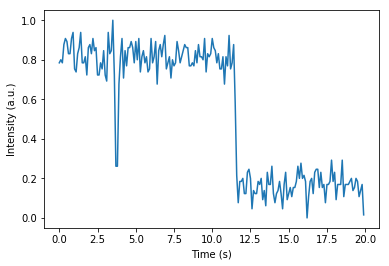

In [375]:
plt.plot(time_axis, scaled_data_cy5[sorting_index[1]])
plt.xlabel('Time (s)')
plt.ylabel('Intensity (a.u.)')
plt.savefig('Class 0 standard.png', dpi=300)

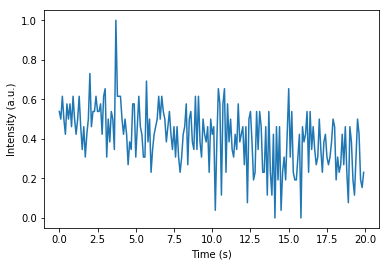

In [376]:
plt.plot(time_axis, scaled_data_cy5[64050])
plt.xlabel('Time (s)')
plt.ylabel('Intensity (a.u.)')
plt.savefig('Class 1 standard.png', dpi=300)

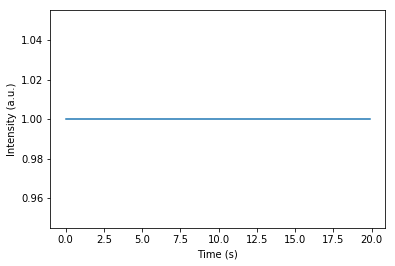

In [377]:
plt.plot(time_axis, scaled_data_cy5[64050])
plt.xlabel('Time (s)')
plt.ylabel('Intensity (a.u.)')
plt.savefig('Class 1 standard.png', dpi=300)

plt.plot(time_axis, scaled_data_cy5[33104])
plt.xlabel('Time (s)')
plt.ylabel('Intensity (a.u.)')
plt.savefig('Class 2 standard.png', dpi=300)

In [385]:
labels_all = dtw_classification(scaled_data_cy5, 3, n_frames, [sorting_index[1], 64050, 33104])

Time passed: 6140.986400127411


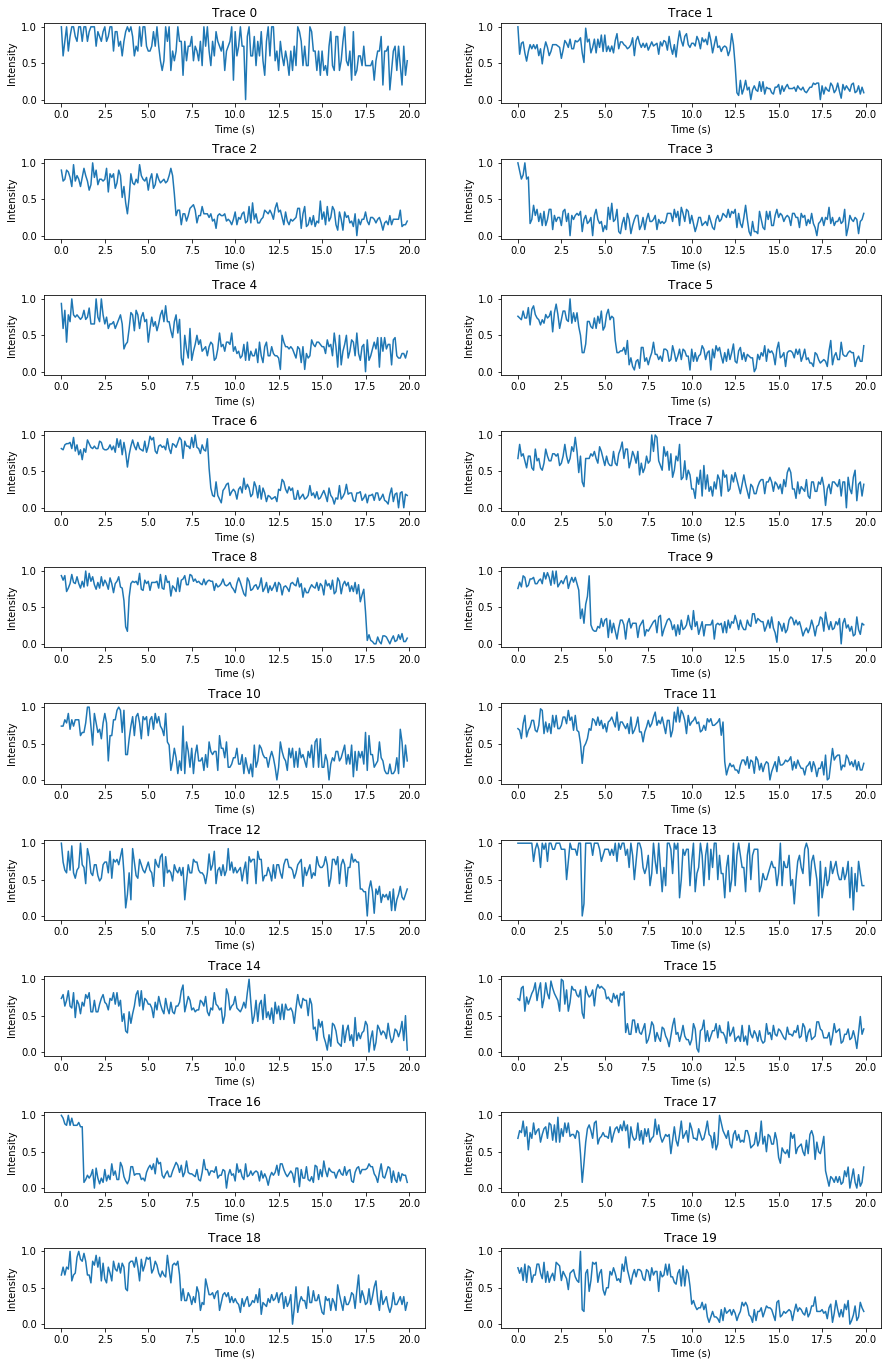

In [406]:
classes = class_extractor(labels_all, 3)
plot_traces(20, scaled_data_cy5, np.random.choice(classes[0], size=(20,)))
plt.savefig('30s all, Class 0, 20 randome traces.png', dpi=300)

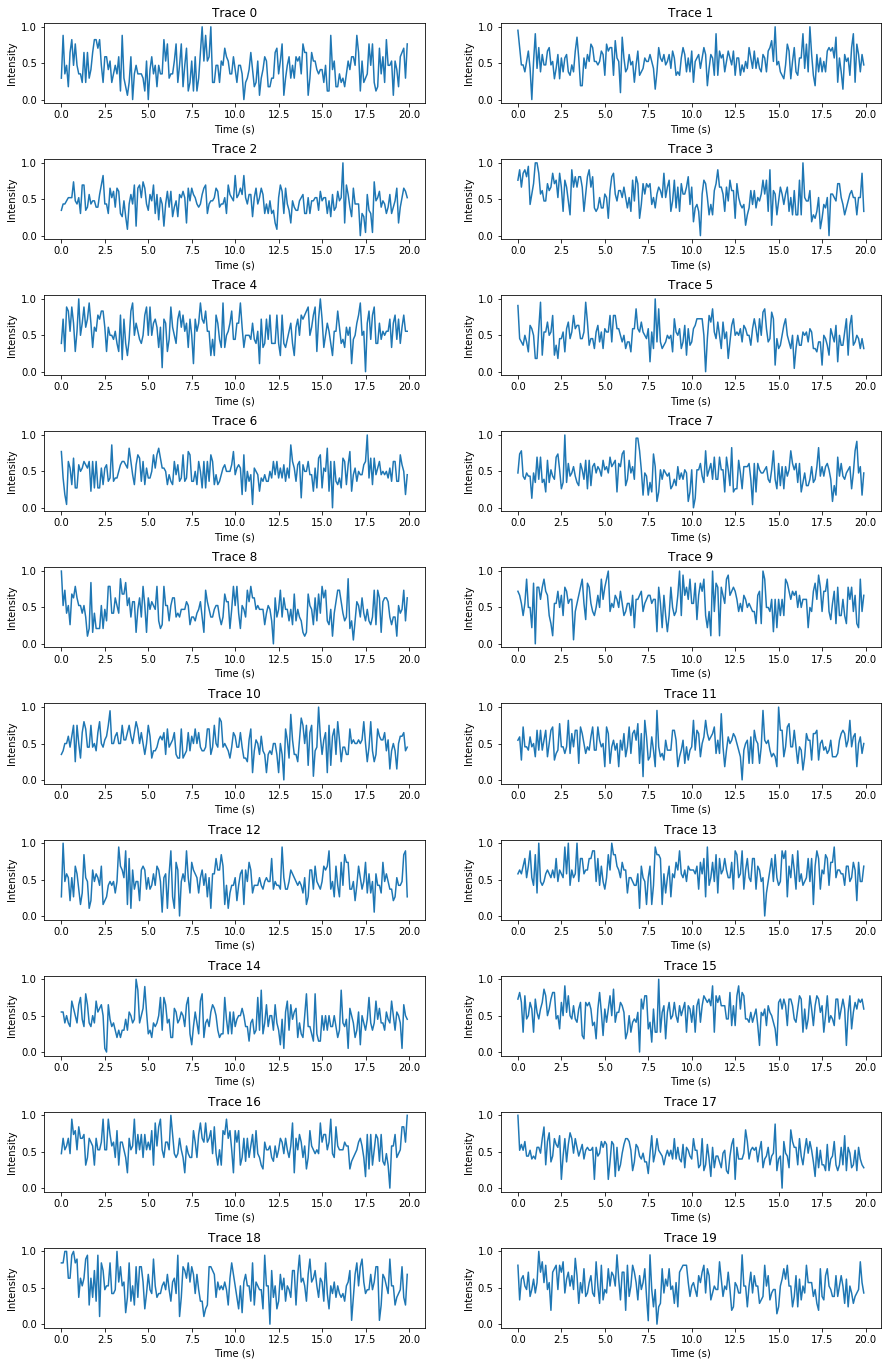

In [387]:
plot_traces(20, scaled_data_cy5, np.random.choice(classes[1], size=(20,)))
plt.savefig('30s all, Class 1, 20 randome traces.png', dpi=300)

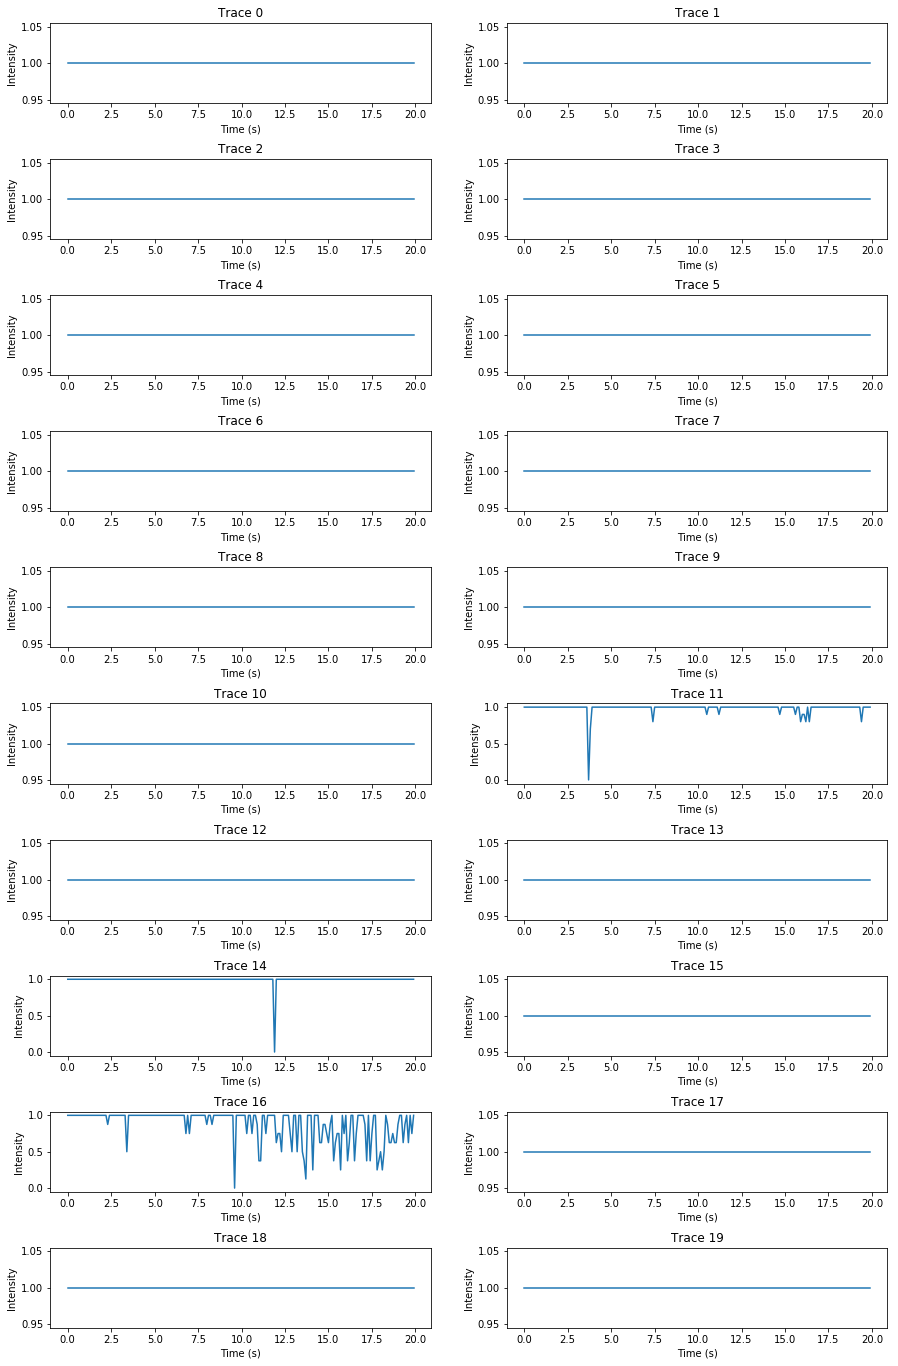

In [388]:
plot_traces(20, scaled_data_cy5, np.random.choice(classes[2], size=(20,)))
plt.savefig('30s all, Class 2, 20 randome traces.png', dpi=300)

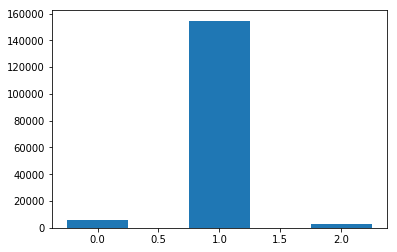

In [405]:
plt.bar([0, 1, 2], [  5723., 154661.,   3098.], width=0.5)
plt.savefig('30s all, class histogram.png', dpi=300)

In [397]:
arr

(array([  5723., 154661.,   3098.]),
 array([0.        , 0.66666667, 1.33333333, 2.        ]),
 <a list of 3 Patch objects>)

In [408]:
a = np.array([[2, 2], [3, 4]])
np.mean(a, axis=1)

array([2. , 3.5])